# Image classification
The example we are going through here is one of the best known examples in machine learning in general. This is why it is often referred to as the "hello world" example of ML. It classifies the MNIST dataset, a collection of 70000 hand written digits between 0 and 9.

### MNIST

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

You can find the full description of the dataset in the collapsed cell:

In [2]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [3]:
mnist.keys()  # We only need images (data) and labels (target) in this notebook

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Let's see what our dataset is all about

In [5]:
X.shape

(70000, 784)

In [6]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [7]:
y.shape

(70000,)

It seems the 784 refers to the number of pixels in the low-res images (28x28).

In [8]:
28 * 28

784

Let's create a function to display our images. We first have to reshape the "flattend" tensor into two dimensions.

In [9]:
import matplotlib.pyplot as plt

Here, we define the font and label sizes for the figures in the notebook.

In [10]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

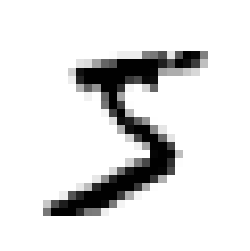

In [11]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.figure(figsize = (3,3))
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit);

Let's check the label if this is a 5 or a 3.

In [12]:
y[0]

'5'

In [13]:
import numpy as np

Let's display some random images from the set.

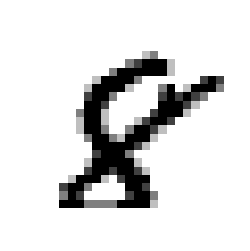

In [14]:
some_digit_number = np.random.randint(0,69999)
some_digit = X[some_digit_number]
plot_digit(some_digit);

Time to separate our data into training and test data:

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

In [17]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((56000, 784), (56000,), (14000, 784), (14000,))

In an image classification problem, the images usually are in a two-dimensional shape. To make it more realistic, we will reshape them into the correct form, even though we will later have to flatten them again, when we build our neural network.

In [18]:
X_train = X_train.reshape(56000,28,28)
X_test = X_test.reshape(14000,28,28)
X_train.shape, X_test.shape

((56000, 28, 28), (14000, 28, 28))

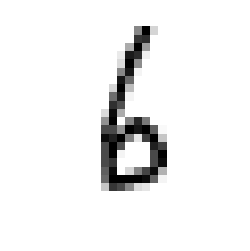

In [19]:
plot_digit(X_train[0])

### Creating a multi-class classifier
We will now build our multi-class classification NN. This is similar to what we've done before. However, first we need to pre-process our data a little. Neural networks work very well with normalized data, so this is what we are going to do.
The images in the MNIST data set are gray-scale images with pixel values between 0 and 255, where 0 is black and 255 white. Instead of using a fancy normalization function, we will simply divide our data by the max value (minus the min value, which is 0).

In [20]:
X_train.max(), X_train.min(), X_test.max(), X_test.min()

(255, 0, 255, 0)

In [21]:
X_train, X_test = X_train / 255.0, X_test / 255.0

In [22]:
X_train.max(), X_train.min(), X_test.max(), X_test.min()

(1.0, 0.0, 1.0, 0.0)

In [23]:
import tensorflow as tf

2025-11-04 15:27:34.075419: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-04 15:27:34.075490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-04 15:27:34.076255: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-04 15:27:34.082062: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


The model we are building is similar to what we've had before.
However, we do have some things that are new to us:
* We begin with a flatten layer. This transforms our two-dimensional images back into a one-dimensional tensor.
* We pass the input_shape to the first layer
* There is a dropout layer, that randomly drops 20% of all connections (weights) between the previous dense layer and the next. By doing this, we ensure that our model generalizes well and does not just "learn" the dominant paths through the network.
* The activation function of the output layer is softmax (returning probabilities), since we are dealing with a mult-class classification problem.
* The output layer has as many units (neurons) as there are classes

In [24]:
X_train.shape

(56000, 28, 28)

In [25]:
X_train.dtype, y_train.dtype

(dtype('float64'), dtype('O'))

In [26]:
y_train = np.array(y_train, dtype="int32")

In [27]:
y_test = np.array(y_test, dtype="int32")

In [28]:
y_train, y_test

(array([6, 1, 6, ..., 2, 1, 7], dtype=int32),
 array([1, 3, 2, ..., 1, 8, 8], dtype=int32))

In [29]:
import tensorflow as tf

In [30]:
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation = "softmax")
])

2025-11-04 15:27:37.702588: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43604 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:41:00.0, compute capability: 8.6


In [31]:
model_1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [32]:
model_1.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5


2025-11-04 15:27:39.296246: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fcfbdfd7c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-04 15:27:39.296301: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2025-11-04 15:27:39.301762: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-04 15:27:39.321479: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1762266459.420724 1974350 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1750/1750 [==============================] - 4s 2ms/step - loss: 0.3081 - accuracy: 0.9098 - val_loss: 0.1509 - val_accuracy: 0.9561
Epoch 2/5
1750/1750 [==============================] - 3s 2ms/step - loss: 0.1492 - accuracy: 0.9561 - val_loss: 0.1129 - val_accuracy: 0.9670
Epoch 3/5
1750/1750 [==============================] - 3s 2ms/step - loss: 0.1130 - accuracy: 0.9651 - val_loss: 0.0999 - val_accuracy: 0.9707
Epoch 4/5
1750/1750 [==============================] - 3s 2ms/step - loss: 0.0917 - accuracy: 0.9713 - val_loss: 0.0883 - val_accuracy: 0.9746
Epoch 5/5
1750/1750 [==============================] - 3s 2ms/step - loss: 0.0778 - accuracy: 0.9751 - val_loss: 0.0801 - val_accuracy: 0.9766


In [33]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Confusion matrix

Let's make some predictions

In [34]:
y_pred = model_1.predict(X_test)

438/438 [==============================] - 0s 679us/step


y_pred gives us all the predicted probabilities for the whole dataset. However, we are interested in which class got the highest prediction.
We can achieve this with the `tf.argmax()` function.

In [35]:
y_pred

array([[3.63119916e-08, 9.99741614e-01, 1.93603963e-04, ...,
        3.67316752e-05, 3.70945259e-06, 5.41994005e-09],
       [9.36322617e-11, 1.18660822e-07, 6.54667645e-08, ...,
        2.34203212e-11, 1.81429550e-06, 2.10605431e-05],
       [9.41842586e-08, 7.26165090e-05, 9.99738753e-01, ...,
        1.64183582e-08, 5.53678365e-05, 2.06723744e-12],
       ...,
       [3.47068485e-10, 9.99453604e-01, 3.91164718e-07, ...,
        1.54127774e-05, 5.14748899e-05, 6.44428510e-05],
       [1.29767795e-05, 8.78622775e-09, 9.36922952e-05, ...,
        1.38437724e-06, 9.99550879e-01, 2.24237701e-05],
       [2.99233652e-05, 2.35458847e-10, 3.72165664e-06, ...,
        3.74143724e-07, 9.99902844e-01, 1.92412335e-06]], dtype=float32)

In [36]:
y_preds = tf.argmax(y_pred, axis=1)

In [37]:
y_preds

<tf.Tensor: shape=(14000,), dtype=int64, numpy=array([1, 3, 2, ..., 1, 8, 8])>

In [38]:
y_test

array([1, 3, 2, ..., 1, 8, 8], dtype=int32)

Now, we can easily make some confusion matrices to analyse our data more easily.
First, we will display the absolute numbers in the confusion matrix.

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay

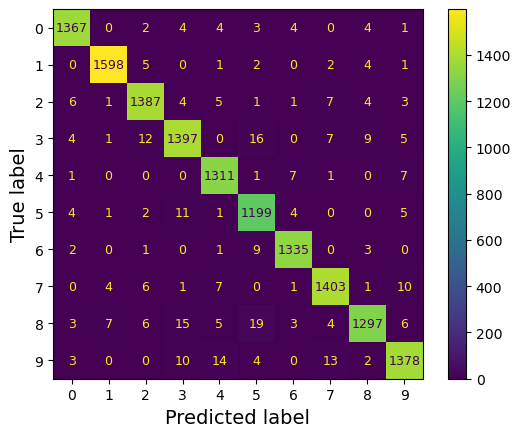

In [40]:
plt.rc('font', size=9)  # make the text smaller
ConfusionMatrixDisplay.from_predictions(y_test, y_preds)
plt.show()

Percentages can make it easier to interpret, so let's have a look at the CM again.

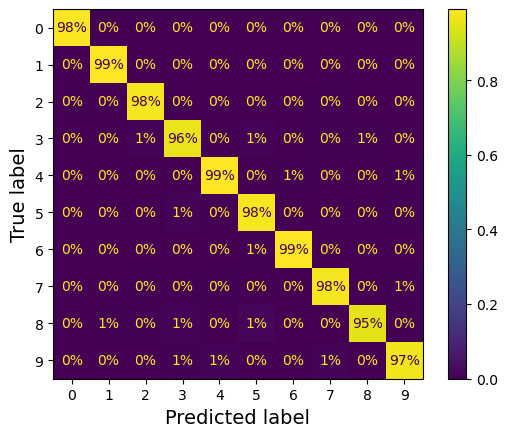

In [41]:
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_test, y_preds,
                                        normalize="true", values_format=".0%")
plt.show()

It gets even more interesting, when we get the weighted errors. For example, we can see that a high percentage of all errors that happened when trying to interpret the number 1 were predicted as 2.

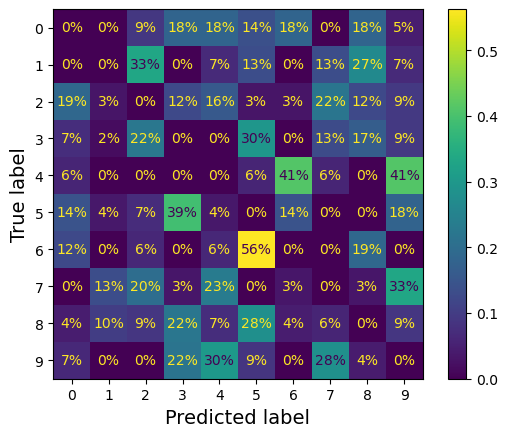

In [42]:
sample_weight = (y_preds != y_test)
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_test, y_preds,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()

We can also normalise the errors column-wise.

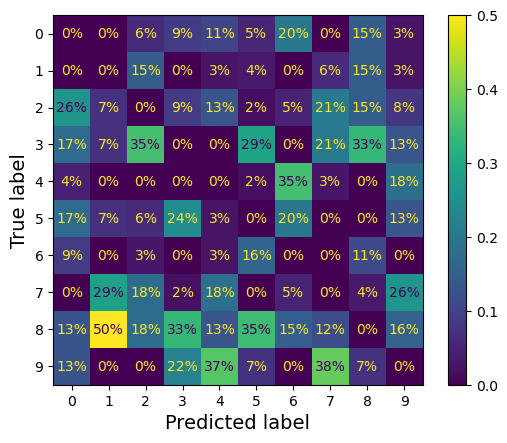

In [43]:
sample_weight = (y_preds != y_test)
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_test, y_preds,
                                        sample_weight=sample_weight,
                                        normalize="pred", values_format=".0%")
plt.show()